<h1 style = "color: skyblue">Regression of Used Car Prices</h1>

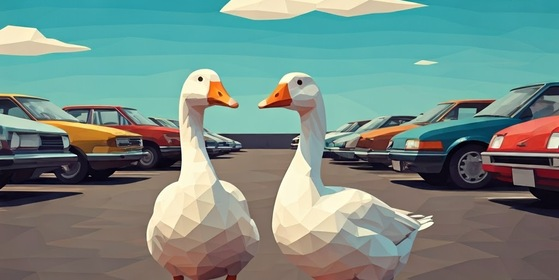

# 1. **Introduction**

<h3 style = "color: orange"> Description </h3>

<p> The dataset for this competition (both train and test) was generated from a deep learning model trained on the Used Car Price Prediction Dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance. </p>

<h3 style = "color: orange"> Goal </h3>

<p> The goal of this competition is to predict the price of used cars based on various attributes. </p>

# 2. **Importing**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/price-cars-prediction-eda-blending/__results__.html
/kaggle/input/price-cars-prediction-eda-blending/submission.csv
/kaggle/input/price-cars-prediction-eda-blending/__notebook__.ipynb
/kaggle/input/price-cars-prediction-eda-blending/__output__.json
/kaggle/input/price-cars-prediction-eda-blending/custom.css
/kaggle/input/price-cars-prediction-eda-blending/__results___files/__results___40_0.png
/kaggle/input/price-cars-prediction-eda-blending/__results___files/__results___40_14.png
/kaggle/input/price-cars-prediction-eda-blending/__results___files/__results___60_0.png
/kaggle/input/price-cars-prediction-eda-blending/__results___files/__results___53_0.png
/kaggle/input/price-cars-prediction-eda-blending/__results___files/__results___63_0.png
/kaggle/input/price-cars-prediction-eda-blending/__results___files/__results___40_12.png
/kaggle/input/price-cars-prediction-eda-blending/__results___files/__results___46_0.png
/kaggle/input/price-cars-prediction-eda-blending/__results_

In [2]:
# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
import re

# Training, evaluation and prediction
import numpy as np
import lightgbm as lgbm
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# 2. **Data Visualization**

In [3]:
# train.csv
train_cars = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
train_cars.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
# test.csv
test_cars = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
test_cars.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [5]:
original_cars = pd.read_csv('/kaggle/input/used-car-price-prediction-dataset/used_cars.csv')
original_cars.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [6]:
# count of NaN values for train.csv and test.csv
print(f"Number of NaN values for train.csv is {train_cars.isna().sum().sum()}")
print(f"Number of NaN values for test.csv is {test_cars.isna().sum().sum()}")

Number of NaN values for train.csv is 28954
Number of NaN values for test.csv is 19254


In [7]:
# columns with NaN values for train.csv and test.csv

train_nan_values = train_cars.columns[train_cars.isna().any()]
test_nan_values = test_cars.columns[test_cars.isna().any()]
print(f"Features for train.csv with missing values are: {list(train_nan_values)}")
print(f"Features for test.csv with missing values are: {list(test_nan_values)}")
# they are the same

Features for train.csv with missing values are: ['fuel_type', 'accident', 'clean_title']
Features for test.csv with missing values are: ['fuel_type', 'accident', 'clean_title']


In [8]:
# min, max and mean for each numerical column (train.csv and test.csv)
train_model_year = train_cars.describe()['model_year']
train_milage = train_cars.describe()['milage']
train_price = train_cars.describe()['price']

test_model_year = test_cars.describe()['model_year']
test_milage = test_cars.describe()['milage']
print(f"train.csv - model_year -> min: {train_model_year['min']}, max: {train_model_year['max']}, mean: {train_model_year['mean']}")
print(f"train.csv - model_milage -> min: {train_milage['min']}, max: {train_milage['max']}, mean: {train_milage['mean']}")
print(f"train.csv - model_price -> min: {train_price['min']}, max: {train_price['max']}, mean: {train_price['mean']}\n")

print(f"test.csv - model_year -> min: {test_model_year['min']}, max: {test_model_year['max']}, mean: {test_model_year['mean']}")
print(f"test.csv - model_milage -> min: {test_milage['min']}, max: {test_milage['max']}, mean: {test_milage['mean']}")

train.csv - model_year -> min: 1974.0, max: 2024.0, mean: 2015.8299979313965
train.csv - model_milage -> min: 100.0, max: 405000.0, mean: 65705.2951737892
train.csv - model_price -> min: 2000.0, max: 2954083.0, mean: 43878.01617753921

test.csv - model_year -> min: 1974.0, max: 2024.0, mean: 2015.7975256583659
test.csv - model_milage -> min: 100.0, max: 405000.0, mean: 66042.58151006444


In [9]:
# categorical features for train.csv and test.csv
print(f"Categorical features for each dataset are: {list(train_cars.drop(columns = ['id', 'model_year', 'milage', 'price']).columns)}")

Categorical features for each dataset are: ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


# 3. **Exploratory Data Analysis (EDA)**

/tmp/ipykernel_17/1824463591.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


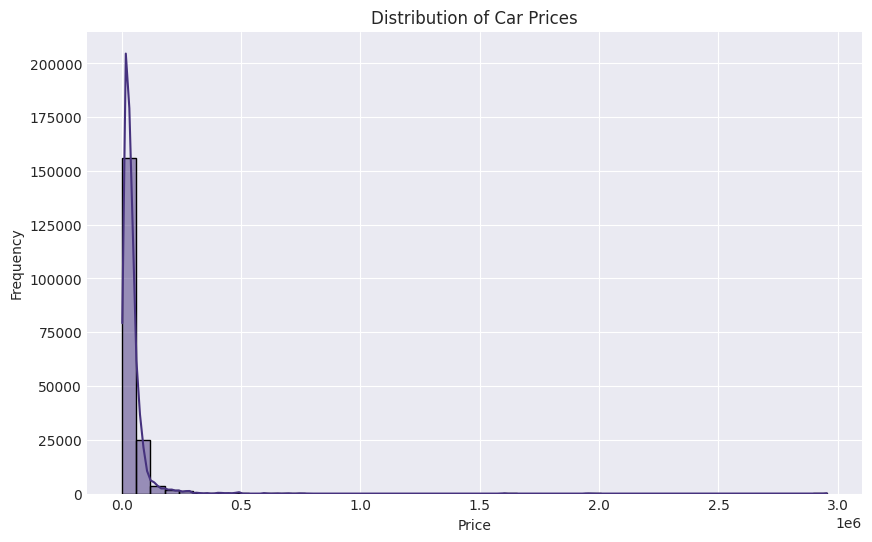

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


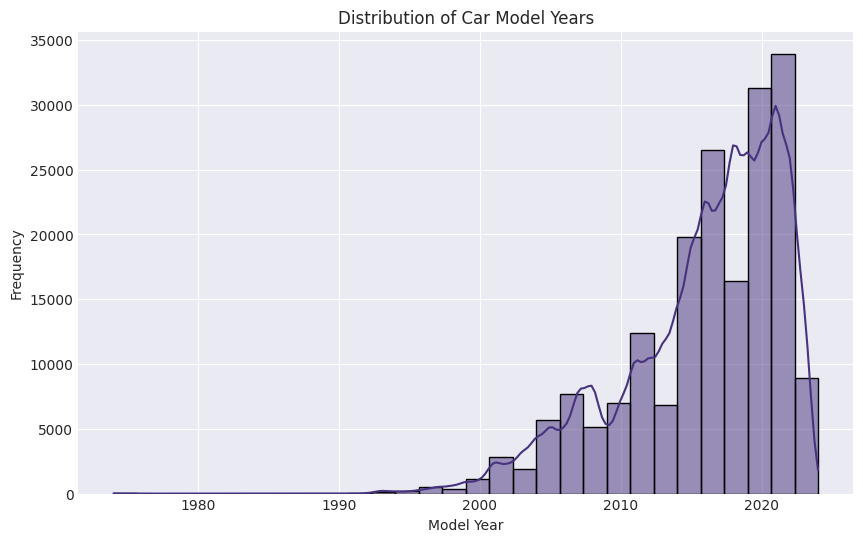

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


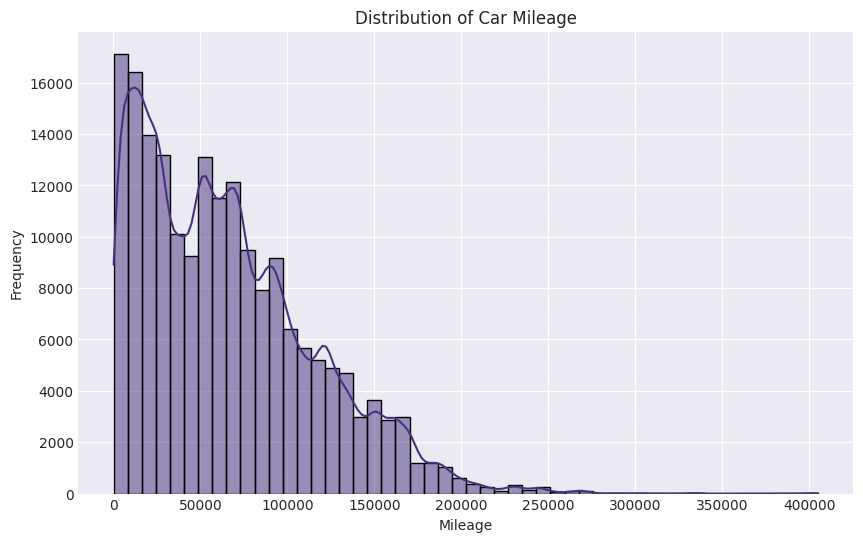

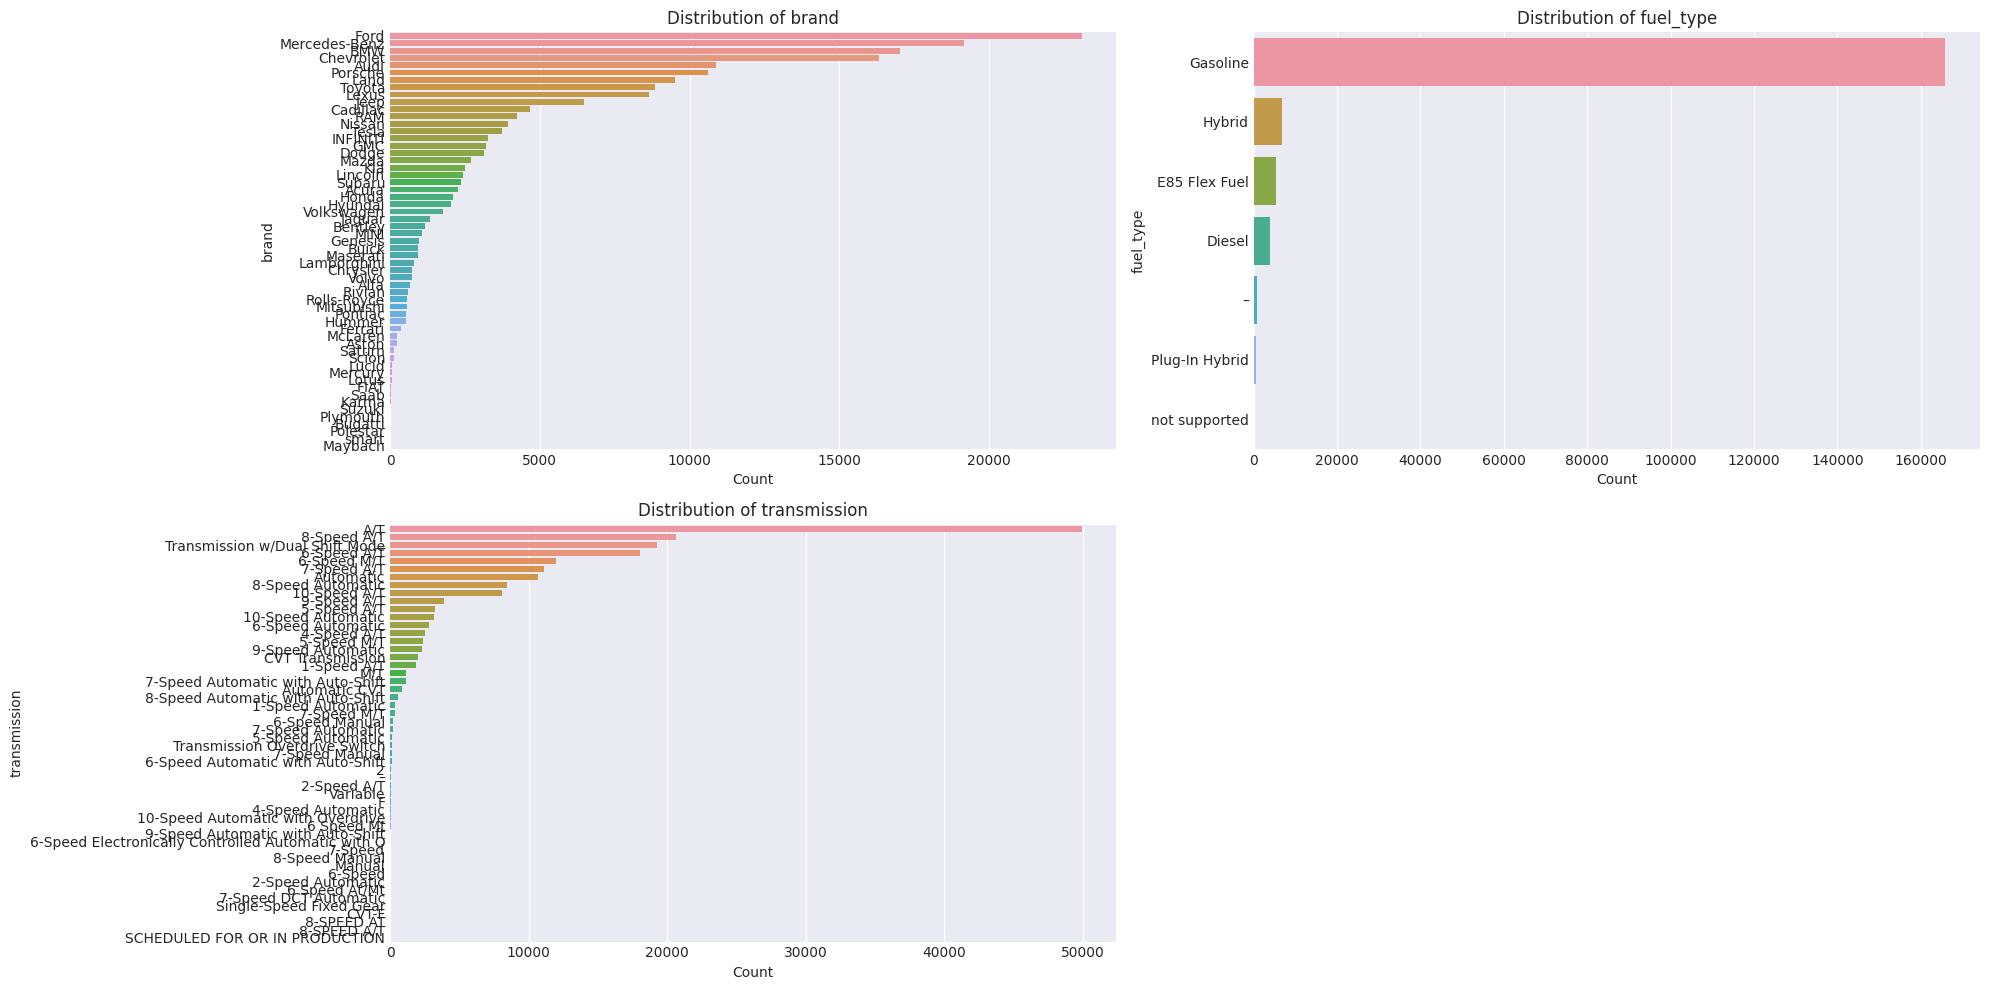

In [10]:
# set up the plotting environment
plt.style.use('seaborn-darkgrid')
sns.set_palette("viridis")

# 1. Univariate Analysis - Distribution of 'price' using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_cars['price'], bins=50, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 2. Univariate Analysis - Distribution of 'model_year' using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_cars['model_year'], bins=30, kde=True)
plt.title('Distribution of Car Model Years')
plt.xlabel('Model Year')
plt.ylabel('Frequency')
plt.show()

# 3. Univariate Analysis - Distribution of 'milage' using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_cars['milage'], bins=50, kde=True)
plt.title('Distribution of Car Mileage')
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.show()

# 4. Univariate Analysis - Count plot for categorical features
# Create a subplot for categorical features like 'brand', 'fuel_type', 'transmission'
categorical_features = ['brand', 'fuel_type', 'transmission']

plt.figure(figsize=(20, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(y=train_cars[feature], order=train_cars[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

Analysis of Univariate Plots

   1. Numerical Features:
    - Price Distribution: The prices are highly skewed to the right, indicating a large number of cars priced lower, with a long tail of higher prices.
    - Model Year Distribution: Most cars are from recent years, with a peak around 2017-2020.
    - Mileage Distribution: The mileage distribution shows a similar right-skewed pattern, indicating most cars have relatively lower mileage, with fewer having extremely high mileage.
   2. Categorical Features:
     - Brand: Certain brands have a higher representation in the dataset, indicating a potential bias in the dataset.
     - Fuel Type: Gasoline is the most common fuel type, followed by Diesel and Hybrid.
     - Transmission: The majority of cars have automatic transmissions.

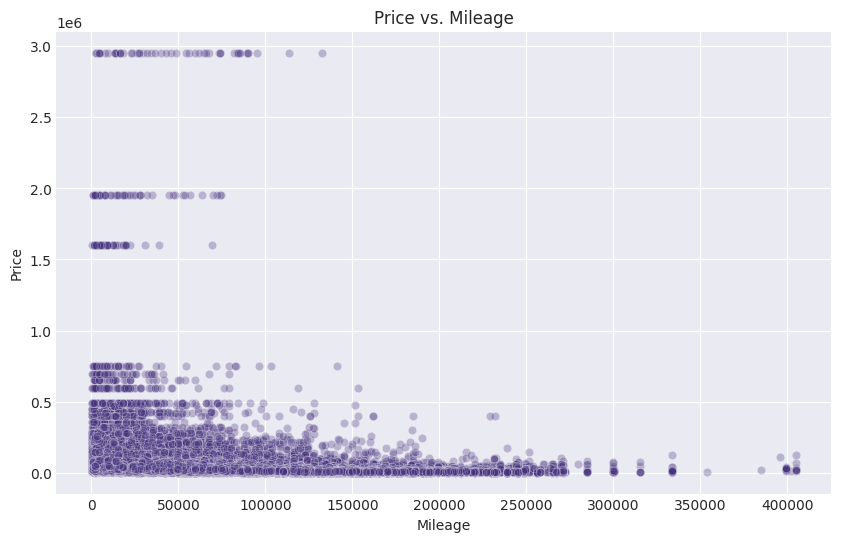

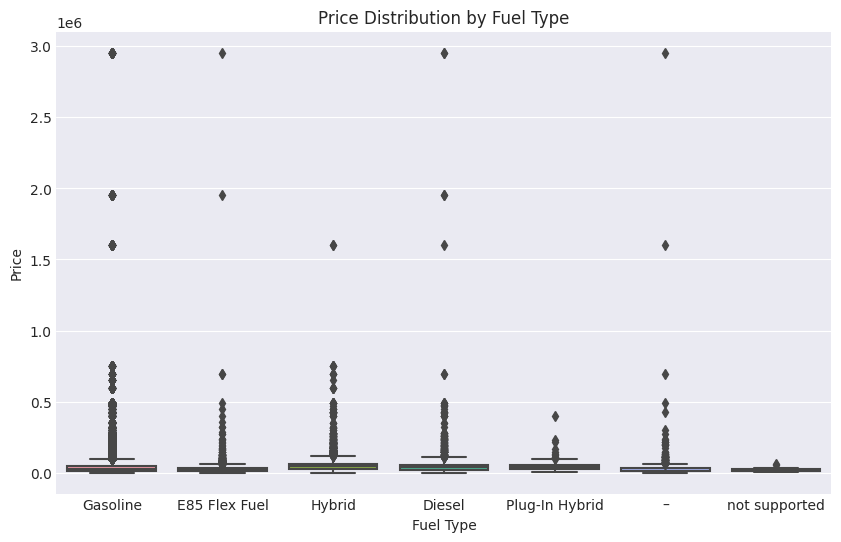

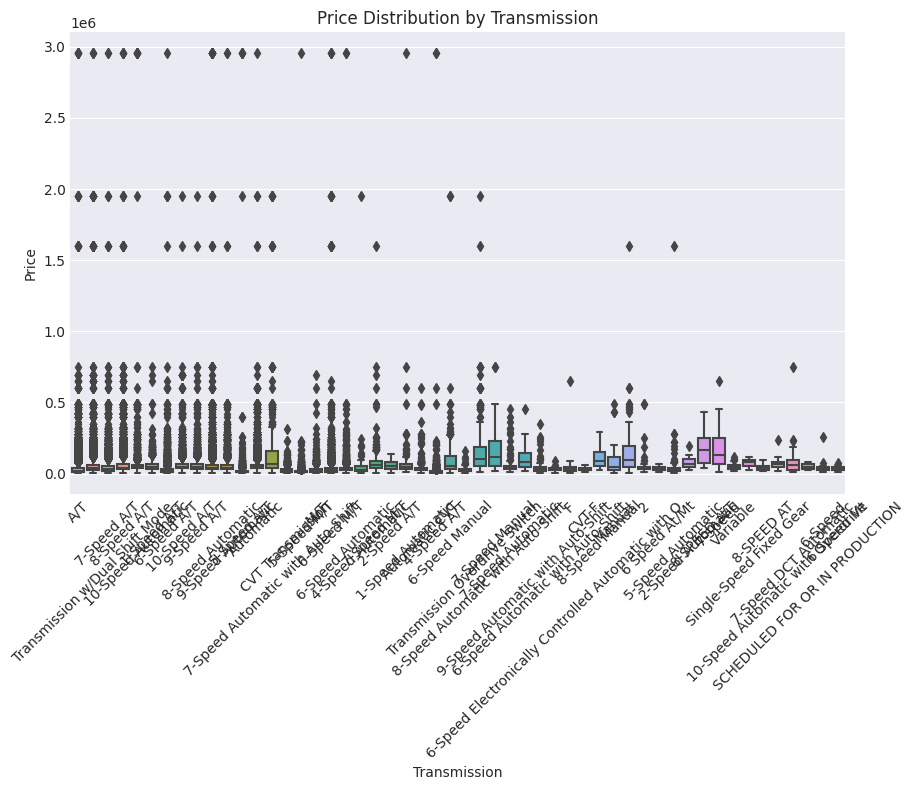

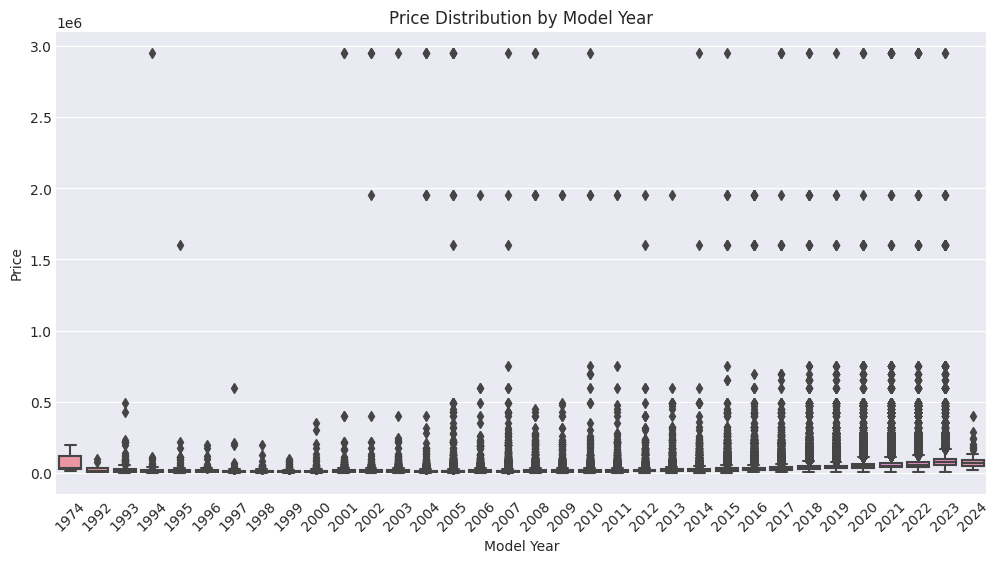

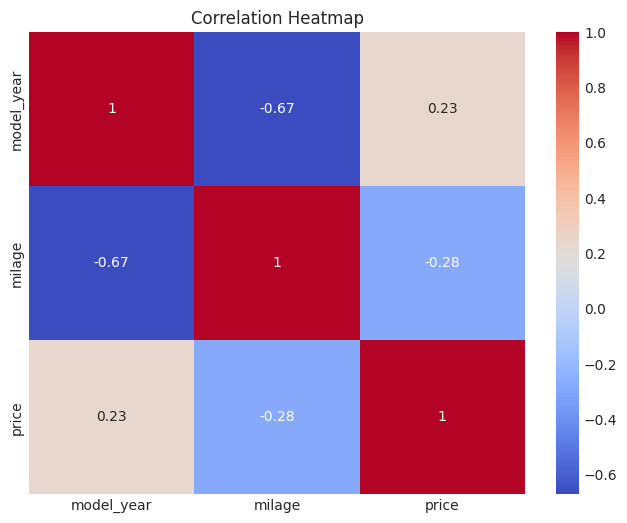

In [11]:
# 2. Bivariate Analysis - Scatter plot for 'price' vs. 'milage'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='milage', y='price', data=train_cars, alpha=0.3)
plt.title('Price vs. Mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

# 2. Bivariate Analysis - Box plot of 'price' vs. 'fuel_type'
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel_type', y='price', data=train_cars)
plt.title('Price Distribution by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

# 3. Bivariate Analysis - Box plot of 'price' vs. 'transmission'
plt.figure(figsize=(10, 6))
sns.boxplot(x='transmission', y='price', data=train_cars)
plt.title('Price Distribution by Transmission')
plt.xlabel('Transmission')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# 4. Bivariate Analysis - Box plot of 'price' vs. 'model_year'
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', data=train_cars)
plt.title('Price Distribution by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# 5. Correlation Heatmap for numeric features
numeric_features = ['model_year', 'milage', 'price']
plt.figure(figsize=(8, 6))
correlation_matrix = train_cars[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Analysis of Bivariate Analysis:

  1. Price vs. Mileage (Scatter Plot): Shows the relationship between mileage and price, with a visible negative trend—higher mileage tends to correspond to lower prices.

  2. Price Distribution by Fuel Type (Box Plot): Compares the price distribution across different fuel types, revealing potential price differences based on fuel type.

  3. Price Distribution by Transmission (Box Plot): Displays the distribution of car prices based on transmission type, highlighting price differences between manual, automatic, or other transmission types.

  4. Price Distribution by Model Year (Box Plot): Demonstrates how the car price varies by model year, indicating that newer models tend to be priced higher.

  5. Correlation Heatmap: A correlation matrix for numeric features (model_year, milage, price) shows the strength of the relationships. Mileage negatively correlates with price, while model year has a positive correlation with price.

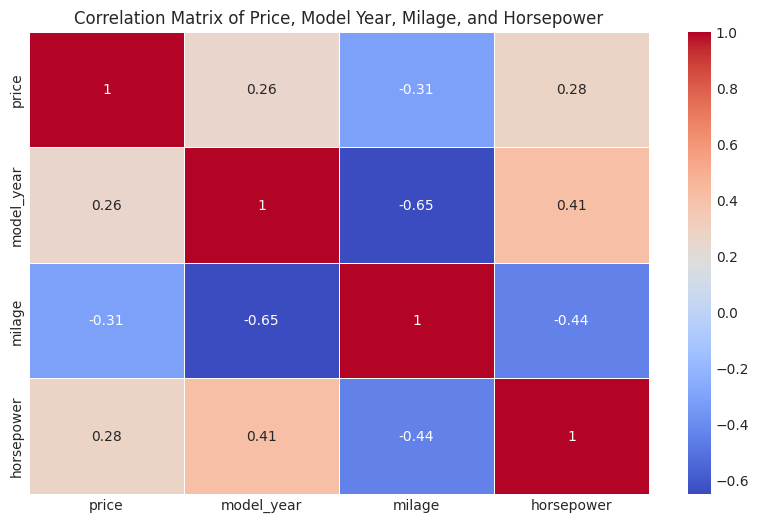

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

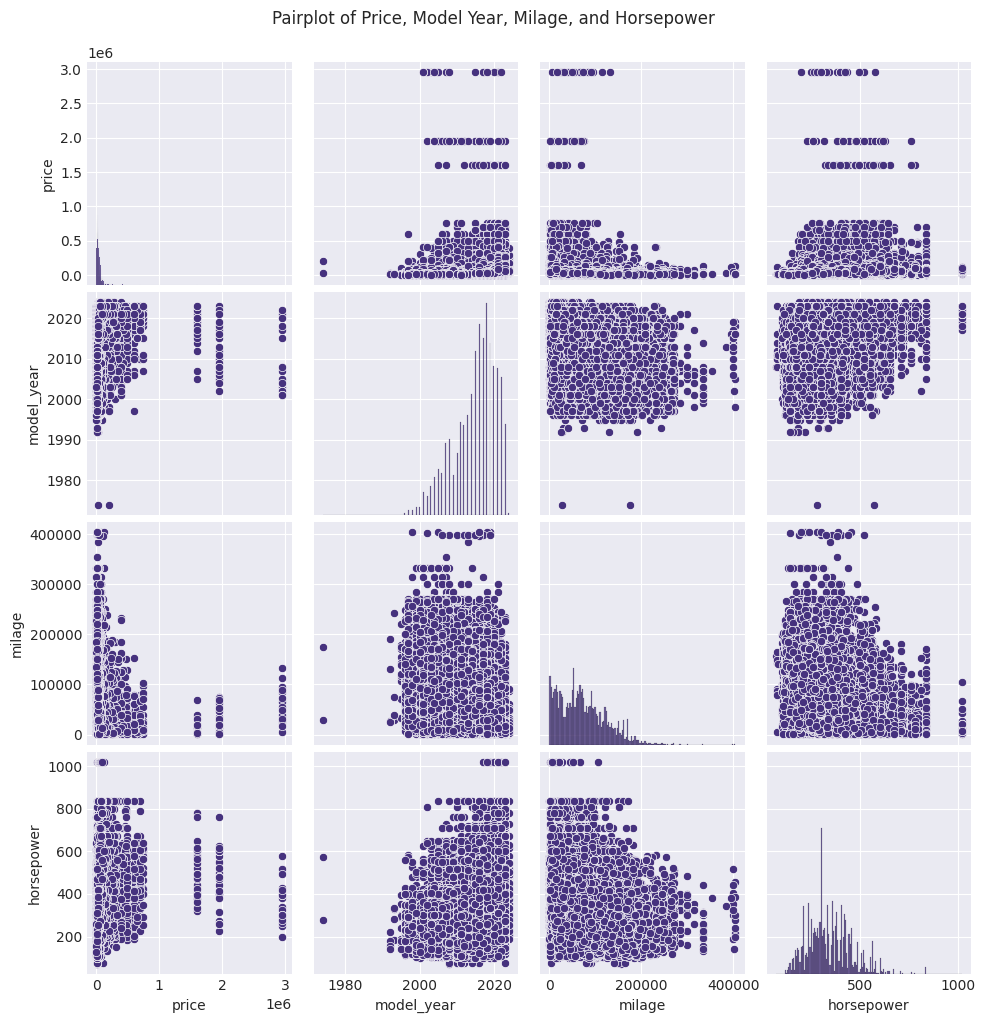

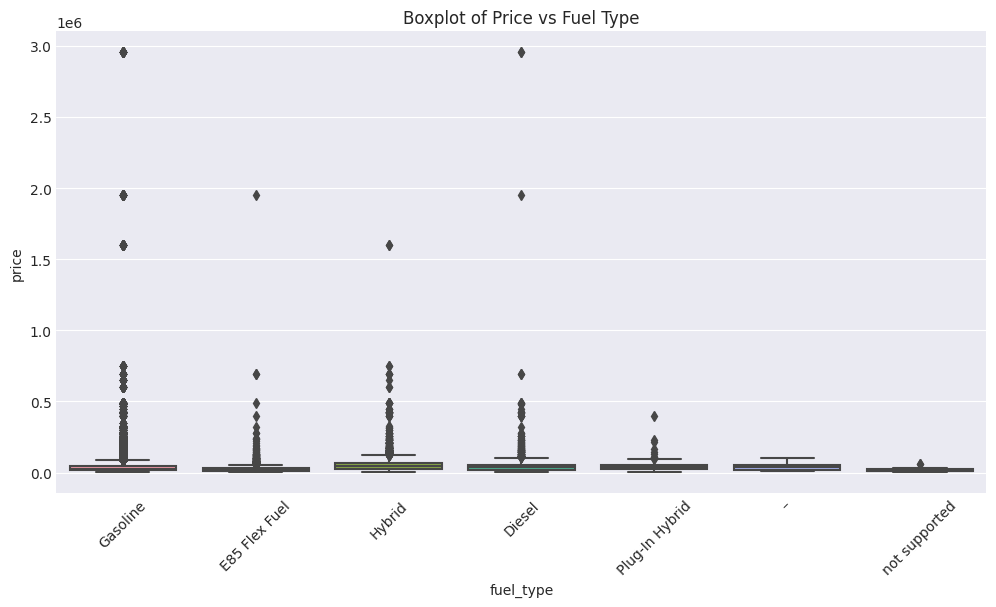

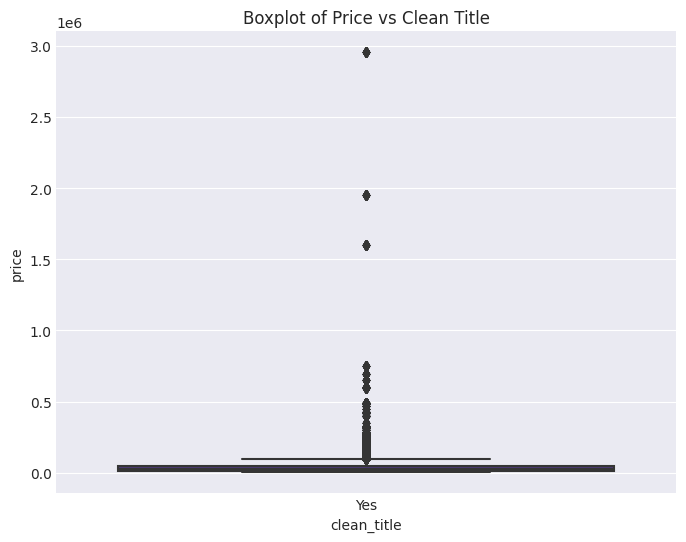

In [12]:
# 3. Analysis of Multivariate Data
data = train_cars[:]
# Convert the 'model_year' and 'milage' columns to numeric
data['model_year'] = pd.to_numeric(data['model_year'], errors='coerce')
data['milage'] = pd.to_numeric(data['milage'], errors='coerce')

# Extract numerical horsepower from the 'engine' column and create a new 'horsepower' column
data['horsepower'] = data['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)

# Drop rows with missing values in relevant columns
data_clean = data.dropna(subset=['price', 'model_year', 'milage', 'horsepower'])

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
corr_matrix = data_clean[['price', 'model_year', 'milage', 'horsepower']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Price, Model Year, Milage, and Horsepower")
plt.show()

# Pairplot to visualize relationships between variables
sns.pairplot(data_clean[['price', 'model_year', 'milage', 'horsepower']])
plt.suptitle("Pairplot of Price, Model Year, Milage, and Horsepower", y=1.02)
plt.show()

# Boxplot to compare categorical variables like 'fuel_type' with 'price'
plt.figure(figsize=(12, 6))
sns.boxplot(x='fuel_type', y='price', data=data_clean)
plt.title("Boxplot of Price vs Fuel Type")
plt.xticks(rotation=45)
plt.show()

# Boxplot to see how clean title affects price
plt.figure(figsize=(8, 6))
sns.boxplot(x='clean_title', y='price', data=data_clean)
plt.title("Boxplot of Price vs Clean Title")
plt.show()

Analysis of Multivariate Data:

   1. Correlation Matrix:
     - The correlation heatmap shows the relationships between price, model_year, milage, and horsepower.
     - There is a moderate positive correlation between price and model_year (~0.6), indicating newer cars tend to have higher prices.
     - Milage has a negative correlation with price, meaning that cars with higher mileage are generally priced lower.
     - Horsepower also shows a positive correlation with price, suggesting cars with higher horsepower are valued more.
     
     
   2. Pairplot:
     - The pairplot helps visualize pairwise relationships between variables.
     - As expected, price generally increases with model_year and horsepower.
     - Milage shows a scattered inverse relationship with price, where cars with lower mileage tend to be priced higher.


   3. Boxplot - Price vs Fuel Type:
     - Different fuel types exhibit a wide range of prices. Gasoline-powered cars have a broader price range, while other types like Flex Fuel have relatively fewer data points but are priced in the middle range.


   4. Boxplot - Price vs Clean Title:
     - Cars with a clean title (i.e., no major accidents or damages) tend to have a significantly higher price than those without, suggesting that a clean title is a strong positive factor in determining car value.

# 4. **Data Preprocessing**

In [13]:
# drop ids from train.csv and test.csv
train_cars = train_cars.drop('id', axis = 1)
test_cars = test_cars.drop('id', axis = 1)

# format the orginal_cars dataset like the train one
original_cars[['milage', 'price']] = original_cars[['milage', 'price']].map(
    lambda x: int(''.join(re.findall(r'\d+', x))))

# concatenate train.csv and orginal dataset for more entries
train_cars = pd.concat([train_cars, original_cars], ignore_index = True)

In [14]:
# functions for feature extraction

# combine more features for multiple types of ages
def age_features(df):
    df['Vehicle_Age'] = 2024 - df['model_year'] # how much old is the vehicle
    df['Milage_Per_Year'] = df['milage'] / df['Vehicle_Age'] # milage per each year
    df['Milage_With_Age'] = df.groupby('Vehicle_Age')['milage'].transform('mean') # mean of vehicle age and milage
    df['Milage_Per_Year_With_Age'] = df.groupby('Vehicle_Age')['Milage_Per_Year'].transform('mean') # mean of milage per year and age
    
    return df

# extract horsepower and engine size and divide them for weight ratio
def engine_features(df):
    
    def horsepower(engine):
        try:
            return float(engine.split('HP')[0])
        except:
            return None
    
    def engine_size(engine):
        try:
            return float(engine.split(' ')[1].replace('L', ''))
        except:
            return None
    
    df['Horsepower'] = df['engine'].apply(horsepower)
    df['Engine_Size'] = df['engine'].apply(engine_size)
    df['Power_To_Weight_Ratio'] = df['Horsepower'] / df['Engine_Size']
    
    return df

# make a different feature for the most high priced car brands
def luxury_features(df):
    luxury_brands =  ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land', 
                        'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini', 
                        'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0) # 1 if the car is luxury or not
    
    return df

In [15]:
# apply the functions to train.csv and test.csv
train_cars = age_features(train_cars)
test_cars = age_features(test_cars)

train_cars = luxury_features(train_cars)
test_cars = luxury_features(test_cars)

In [16]:
# handle missing categorical values since there are just categorical missing values
def missing_categorical_values(df):
    cat_features = ['brand','model','fuel_type','engine','transmission','ext_col','int_col','accident','clean_title']
    noise_features = ['model','engine','transmission','ext_col','int_col']
    
    # handle noise features
    for col in noise_features:
        df.loc[df[col].value_counts(dropna = False)[df[col]].values < 100, col] = 'noise' # no. of values under 100 are noise clearly
    
    # handle categorical missing values
    for col in cat_features:
        df[col] = df[col].fillna('missing')
        df[col] = df[col].astype('category')
    
    return df

In [17]:
# apply them to train.csv and test.csv for handling missing values
train_cars = missing_categorical_values(train_cars)
test_cars = missing_categorical_values(test_cars)

In [18]:
# check again for missing features
print(f"Number of NaN values for train.csv is {train_cars.isna().sum().sum()}")
print(f"Number of NaN values for test.csv is {test_cars.isna().sum().sum()}")

Number of NaN values for train.csv is 0
Number of NaN values for test.csv is 0


# 5. **Training, prediction and evaluation**

In [19]:
# split data
X = train_cars.drop('price', axis = 1) # features
y = train_cars['price'] # label / target

In [20]:
# params trained from https://www.kaggle.com/code/backpaker/current-9-14-2nd-place-solution/notebook
lgb_params_1 ={

    'learning_rate': 0.017521301504983752,
    'max_depth': 42,
    'reg_alpha': 0.06876635751774487, 
    'reg_lambda': 9.738899198284985,
    'num_leaves': 131,
    'subsample': 0.2683765421728044,
    'colsample_bytree': 0.44346036599709887,
    'n_estimators': 1000,
    'random_state': 42,
    'extra_tree' : True,
    'verbose' : -1
}

lgb_params_2 ={

    'learning_rate': 0.017521301504983752,
    'max_depth': 42,
    'reg_alpha': 0.06876635751774487, 
    'reg_lambda': 9.738899198284985,
    'num_leaves': 131,
    'subsample': 0.2683765421728044,
    'colsample_bytree': 0.44346036599709887,
    'n_estimators': 1000,
    'random_state': 42,
    'verbose' : -1
}

cat_params={
    'learning_rate':0.042,
    'iterations':1000,
    'depth':10,
    'random_strength' : 10,
    'cat_features': ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'],
    'l2_leaf_reg':0.3,
    'random_seed':42,
    'early_stopping_rounds': 200,
}

# split the data for validation
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

# lists for models and their RMSE scores
LGBM_model = [] # lightgbm regressor model
CAT_model = [] # cat regressor model
rmse_scores_lgbm = [] # scores for lightgbm
rmse_scores_cat = [] # scores for cat regressor model

# callbacks for displaying more info and stopping in case of too much divergence
callbacks = [log_evaluation(period = 150), early_stopping(stopping_rounds = 200)]

# training and evaluating
for train_idx, test_idx, in kf.split(X):
    # splitting for train and test data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # making lgb datasets for using
    train_data = lgbm.Dataset(X_train, label = y_train)
    test_data = lgbm.Dataset(X_test, label = y_test, reference = train_data)
    
    # train the lgb models
    model_1 = lgbm.train(lgb_params_1,
                      train_data,
                      valid_sets=[train_data, test_data],
                      valid_names=['train', 'valid'],
                      callbacks=callbacks        
                      )
    model_2 = lgbm.train(lgb_params_2,
                  train_data,
                  valid_sets=[train_data, test_data],
                  valid_names=['train', 'valid'],
                  callbacks=callbacks        
                  )
    # after add to lgbm list the models trained
    LGBM_model.append(model_1)
    LGBM_model.append(model_2)
    
    # make prediction with them
    y_pred = model_1.predict(X_test) * 0.5 + model_2.predict(X_test) * 0.5
    
    # find out the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores_lgbm.append(rmse)
    
    print(f'LGBM Fold RMSE: {rmse}')
    
    # initialize catboostregessor model
    model_cat = CatBoostRegressor(**cat_params)
    
    # make datasets for catboostregessor
    train_pool = Pool(X_train, y_train, cat_features = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'])
    test_pool = Pool(X_test, y_test, cat_features = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'])
    
    # train the model
    model_cat.fit(train_pool, eval_set = test_pool, verbose = 300)
    
    # add to list, make prediction and then find out the rmse
    CAT_model.append(model_cat)
    y_pred_cat = model_cat.predict(X_test)
    rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
    rmse_scores_cat.append(rmse_cat)
    
    print(f'CAT Fold RMSE: {rmse_cat}')

print(f'Mean LGBM RMSE: {np.mean(rmse_scores_lgbm)}')
print(f'Mean CAT RMSE: {np.mean(rmse_scores_cat)}')

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[150]	train's l2: 5.08568e+09	valid's l2: 5.68035e+09
[300]	train's l2: 4.94205e+09	valid's l2: 5.65264e+09
[450]	train's l2: 4.84184e+09	valid's l2: 5.6601e+09
Early stopping, best iteration is:
[284]	train's l2: 4.95488e+09	valid's l2: 5.65207e+09
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's l2: 4.59159e+09	valid's l2: 5.65656e+09
[300]	train's l2: 4.16164e+09	valid's l2: 5.66924e+09
Early stopping, best iteration is:
[180]	train's l2: 4.48449e+09	valid's l2: 5.65322e+09
LGBM Fold RMSE: 75117.87038308244
0:	learn: 77927.2301893	test: 80631.4201990	best: 80631.4201990 (0)	total: 525ms	remaining: 8m 44s
300:	learn: 70097.7837711	test: 75366.6712616	best: 75366.6712616 (300)	total: 1m 48s	remaining: 4m 10s
600:	learn: 63774.1576819	test: 75391.5430047	best: 75281.9770364 (463)	total: 4m 6s	remaining: 2m 43s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 75281.97704
bestIteration = 463

Shrink model to first 464 iterations.
CAT Fold RMSE: 75281.97703644205


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[150]	train's l2: 5.3344e+09	valid's l2: 4.65857e+09
[300]	train's l2: 5.18575e+09	valid's l2: 4.63073e+09
[450]	train's l2: 5.08788e+09	valid's l2: 4.63731e+09
Early stopping, best iteration is:
[328]	train's l2: 5.16748e+09	valid's l2: 4.6305e+09
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's l2: 4.81952e+09	valid's l2: 4.62521e+09
[300]	train's l2: 4.36457e+09	valid's l2: 4.63606e+09
Early stopping, best iteration is:
[185]	train's l2: 4.69306e+09	valid's l2: 4.62083e+09
LGBM Fold RMSE: 67939.2211312691
0:	learn: 79498.4108779	test: 74044.9457381	best: 74044.9457381 (0)	total: 636ms	remaining: 10m 35s
300:	learn: 71846.1104673	test: 68194.2681438	best: 68194.2681438 (300)	total: 1m 55s	remaining: 4m 28s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 68144.74983
bestIteration = 394

Shrink model to first 395 iterations.
CAT Fold RMSE: 68144.74983004155


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[150]	train's l2: 5.29074e+09	valid's l2: 4.84702e+09
[300]	train's l2: 5.14591e+09	valid's l2: 4.81707e+09
[450]	train's l2: 5.04384e+09	valid's l2: 4.82111e+09
Early stopping, best iteration is:
[300]	train's l2: 5.14591e+09	valid's l2: 4.81707e+09
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's l2: 4.75784e+09	valid's l2: 4.85293e+09
[300]	train's l2: 4.29819e+09	valid's l2: 4.89411e+09
Early stopping, best iteration is:
[160]	train's l2: 4.71728e+09	valid's l2: 4.85251e+09
LGBM Fold RMSE: 69462.90158472417
0:	learn: 79209.8994658	test: 75529.9769710	best: 75529.9769710 (0)	total: 457ms	remaining: 7m 36s
300:	learn: 71094.6752743	test: 69643.8903432	best: 69635.2259938 (283)	total: 1m 55s	remaining: 4m 28s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 69635.22599
bestIteration = 283

Shrink model to first 284 iterations.
CAT Fold RMSE: 69635.22599377601


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[150]	train's l2: 5.09555e+09	valid's l2: 5.65328e+09
[300]	train's l2: 4.95704e+09	valid's l2: 5.6169e+09
[450]	train's l2: 4.85629e+09	valid's l2: 5.61819e+09
Early stopping, best iteration is:
[330]	train's l2: 4.93427e+09	valid's l2: 5.61546e+09
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's l2: 4.60132e+09	valid's l2: 5.6273e+09
[300]	train's l2: 4.17214e+09	valid's l2: 5.64229e+09
Early stopping, best iteration is:
[170]	train's l2: 4.52826e+09	valid's l2: 5.62343e+09
LGBM Fold RMSE: 74893.3465342021
0:	learn: 77911.9335286	test: 80657.0570778	best: 80657.0570778 (0)	total: 460ms	remaining: 7m 40s
300:	learn: 70046.8736137	test: 75200.2508959	best: 75200.2508959 (300)	total: 1m 52s	remaining: 4m 20s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 75157.31706
bestIteration = 353

Shrink model to first 354 iterations.
CAT Fold RMSE: 75157.31706176781


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[150]	train's l2: 5.09567e+09	valid's l2: 5.69374e+09
[300]	train's l2: 4.9503e+09	valid's l2: 5.65223e+09
[450]	train's l2: 4.8481e+09	valid's l2: 5.6565e+09
Early stopping, best iteration is:
[310]	train's l2: 4.94228e+09	valid's l2: 5.65158e+09
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's l2: 4.57905e+09	valid's l2: 5.68846e+09
[300]	train's l2: 4.13892e+09	valid's l2: 5.70665e+09
Early stopping, best iteration is:
[181]	train's l2: 4.46776e+09	valid's l2: 5.68253e+09
LGBM Fold RMSE: 75213.21851052395
0:	learn: 77791.8995044	test: 81213.3070069	best: 81213.3070069 (0)	total: 458ms	remaining: 7m 37s
300:	learn: 69881.4620031	test: 75455.0029380	best: 75455.0029380 (300)	total: 1m 54s	remaining: 4m 27s
600:	learn: 63786.9191023	test: 75414.2334786	best: 75393.3208202 (402)	total: 4m 14s	remaining: 2m 49s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 75393.32082
bestIteration = 402

Shrink model to first 403 iterations.
CAT Fold RMSE: 75393.3208202383
Mean LGBM RMSE: 72525.31162876035
Mean CAT RMSE: 72722.51814845313


In [21]:
# make prediction on the test data

# firstly with lgbm
LGBM_preds = np.zeros(len(test_cars))
for model in LGBM_model:
    LGBM_preds += model.predict(test_cars) / len(LGBM_model)
    
# secondly with catboost
CAT_preds = np.zeros(len(test_cars))
for model in CAT_model:
    CAT_preds += model.predict(test_cars) / len(CAT_model)
    
 # combine them
test_preds = LGBM_preds * 0.8 + CAT_preds * 0.2

# 5. **Submission**

In [22]:
# use sample submission as a submission modifying the prices with the predicted ones
sample_cars = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
sub_1 = pd.read_csv('/kaggle/input/current-9-14-2nd-place-solution/submission_1.csv')
sub_2 = pd.read_csv('/kaggle/input/price-cars-prediction-eda-blending/submission.csv')
sample_cars['price'] = (0.9 * test_preds + 0.1 * sub_1['price']) * 0.4 + 0.6 * sub_2['price']
sample_cars.to_csv('predictions.csv', index = False)
sample_cars.head()

,id,price
0,188533,18466.542551
1,188534,80318.572733
2,188535,56769.665736
3,188536,30035.231476
4,188537,30885.182666
